In [27]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os

np.random.seed(1)
torch.manual_seed(1)

In [28]:
# Define Force Field

def f_orig(x):
    return torch.transpose(torch.stack([x[:,1], -x[:,0]]),0,1)

def x2xp(x):
    y = torch.ones_like(x)
    y[:,0] = np.e**(0.5*x[:,0])-1
    y[:,1] = np.e**(0.5*x[:,1])-1
    return y

def f(x):
    return torch.transpose(torch.stack([(x[:,0]+1)*torch.log(x[:,1]+1),-(x[:,1]+1)*torch.log(x[:,0]+1)]),0,1)


x = np.linspace(-1,1,num=21)
y = np.linspace(-1,1,num=21)
xx,yy= np.meshgrid(x,y)

input_grid = torch.tensor(np.transpose(np.array([xx.reshape(-1), yy.reshape(-1)])), dtype=torch.float, requires_grad = True)
input_ = x2xp(input_grid)
input_d = input_.shape[1]

def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return torch.autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

# Define Transformer

class T(nn.Module):
    def __init__(self,w=200):
        super(T, self).__init__()
        self.l1 = nn.Linear(input_d,w)
        self.l2 = nn.Linear(w,w)
        self.l3 = nn.Linear(w,input_d)
    
    def forward(self, x, eps=0.1):
        bs = x.shape[0]
        #f = nn.Tanh()
        f = nn.SiLU()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return x + eps*self.x3
    
    #def forward(self, x, eps=0.0):
    #    return self.l0(x)
    
    def transform_f(self, x):
        jac_ts = batch_jacobian(self.forward, x, create_graph=True)
        return torch.matmul(jac_ts, torch.unsqueeze(f(x), dim=2))

In [29]:
# Loss library

# Lie group: for SO(2), g_J = [[0,1],[-1,0]]

def Jp_(f,t,inputs):
    input_d = input_.shape[1]
    jac_f = batch_jacobian(f,inputs,create_graph=True)
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    jac_inv_ts = torch.inverse(jac_ts)

    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)

    # calculate J'
    Jp1 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*hess_t.permute(0,2,1,3).unsqueeze(dim=2)*f(inputs).unsqueeze(dim=1).unsqueeze(dim=2).unsqueeze(dim=3)
    Jp2 = jac_inv_ts.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=4)*jac_ts.unsqueeze(dim=2).unsqueeze(dim=3)*jac_f.permute(0,2,1).unsqueeze(dim=1).unsqueeze(dim=2)
    Jp = Jp1 + Jp2
    Jp = torch.sum(torch.sum(Jp,dim=4),dim=3)
    return Jp

def hess(t, inputs):
    jac_ts = batch_jacobian(t,inputs,create_graph=True)
    
    # get Hessian of t
    gradsss = []
    for i in range(input_d):
        gradss = []
        for j in range(input_d):
            grads = torch.autograd.grad(jac_ts[:,i,j], inputs, torch.ones_like(jac_ts[:,i,j]), create_graph=True, retain_graph=True)[0]
            gradss.append(grads)
        gradss = torch.stack(gradss)
        gradsss.append(gradss)
    # SHAPE
    hess_t = torch.stack(gradsss).permute(2,0,1,3)
    
    return hess_t
    

def off_diag(M,n_part=[2,2]):
    bs = M.shape[0]
    input_d = M.shape[1]
    assert input_d == np.sum(n_part)
    start = 0
    end = n_part[0]
    diag_loss = 0
    for i in range(len(n_part)):
        diag_loss = diag_loss + torch.sum(M[:,start:end, start:end]**2)
        start = end
        end = end + n_part[i]
    return (torch.sum(M**2) - diag_loss)/(batch_size*input_d**2)


def lie_loss(f,t,inputs):
    
    bs = inputs.shape[0]
    # for SO(2)
    g_J = torch.tensor([[0,1],[-1,0]], dtype=torch.float, requires_grad=True)
    Jp = Jp_(f,t,inputs)
    fp = t.transform_f(inputs)
    inputsp = torch.unsqueeze(t(inputs), dim=2)
    
    g_J = torch.unsqueeze(torch.unsqueeze(torch.ones(bs,),dim=1),dim=1) * torch.unsqueeze(g_J, dim=0)
    pde = torch.matmul(torch.matmul(Jp.permute(0,1,2),g_J),inputsp) - torch.matmul(g_J, fp)
    r_mse = torch.mean(inputsp**2)
    loss = torch.mean(pde**2)
    return loss/r_mse

def translation_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)[:,0]
    loss = torch.mean(Jp**2)
    return loss

def modularity_loss(f,t,inputs,n_part=[2,2]):
    Jp = Jp_(f,t,inputs)
    loss = off_diag(Jp,n_part=n_part)
    return loss

def hamiltonicity_loss(f,t,inputs):
    Jp = Jp_(f,t,inputs)
    input_d = inputs.shape[1]
    assert input_d % 2 ==0
    M = torch.zeros(input_d, input_d)
    half_d = int(input_d/2)
    M[:half_d, half_d:] = torch.eye(half_d)
    M[half_d:, :half_d] = -torch.eye(half_d)
    M = torch.tensor(M, dtype=torch.float, requires_grad=True)
    JMMJ = torch.matmul(Jp.permute(0,2,1), M) + torch.matmul(M, Jp)
    loss = torch.mean(JMMJ**2)
    return loss

In [30]:
from celluloid import Camera
fig = plt.figure(figsize=(15,5))
camera = Camera(fig)


# Training a transformer to minimize PDE losses


np.random.seed(0)
torch.manual_seed(0)

t = T(w=400)
epochs = 5000
switch_epoch = 2500
lr_decay_epoch = 500

n_train = input_.shape[0]
batch_size = 128

lr = 1e-3
optimizer = optim.Adam(t.parameters(), lr=lr)

log = 50


losses_ham = []
losses_rot = []

for epoch in range(epochs):

    t.train()
    optimizer.zero_grad()
    
    choices = np.random.choice(n_train, batch_size)
    inputs = input_[choices]
    
    if epoch == switch_epoch:
        for opt_param in optimizer.param_groups:
            lr = 1e-3
            opt_param['lr'] = lr
    
    if (epoch+1) % lr_decay_epoch == 0:
        for opt_param in optimizer.param_groups:
            lr = lr * 0.5
            opt_param['lr'] = lr
    
    '''if epoch < switch_epoch:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_rot = float("nan")
        losses_rot.append(loss_rot)
        losses_ham.append(loss_ham.detach().numpy())
        loss = loss_ham
    else:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_rot = lie_loss(f,t,inputs)
        losses_ham.append(loss_ham.detach().numpy())
        losses_rot.append(loss_rot.detach().numpy())
        loss = loss_ham + loss_rot'''
    
    if epoch < switch_epoch:
        loss_ham = float("nan")
        loss_rot = lie_loss(f,t,inputs)
        losses_ham.append(loss_ham)
        losses_rot.append(loss_rot.detach().numpy())
        loss = loss_rot
    else:
        loss_ham = hamiltonicity_loss(f,t,inputs)
        loss_rot = lie_loss(f,t,inputs)
        losses_ham.append(loss_ham.detach().numpy())
        losses_rot.append(loss_rot.detach().numpy())
        loss = loss_ham + loss_rot
        
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if epoch%log == 0:
        print('Epoch:  %d | Loss_tran: %.4f | Loss_ham: %.4f ' %(epoch, loss_ham, loss_rot))
    
    '''if epoch%log == 0:
        print('Epoch:  %d | Loss_ham: %.4f | Loss_rot: %.4f' %(epoch, loss_ham, loss_rot))
        
        plt.subplot(1,3,1)
        x_orig_ = input_grid.detach().numpy()
        f_orig_ = f_orig(input_grid).detach().numpy()
        plt.quiver(x_orig_[:,0], x_orig_[:,1], f_orig_[:,0], f_orig_[:,1])
        plt.xlim(-2,2)
        plt.ylim(-2,2)
        plt.title("Original")
        
        plt.subplot(1,3,2)
        xt0 = input_
        ft0 = f(input_).detach().numpy()
        xt0 = xt0.detach().numpy()
        plt.quiver(xt0[:,0], xt0[:,1], ft0[:,0], ft0[:,1])
        #plt.xlim(-2,2)
        #plt.ylim(-2,2)
        plt.title("Messed Up")
        
        plt.subplot(1,3,3)
        xt = t(input_).detach().numpy()
        ft = t.transform_f(input_).detach().numpy()
        if epoch == switch_epoch:
            xt_mid = copy.deepcopy(xt)
            ft_mid = copy.deepcopy(ft)
        plt.quiver(xt[:,0], xt[:,1], ft[:,0], ft[:,1])
        plt.text(0.8,0.8,r"$\overline{\{J,M\}^2}$="+"%.4f"%loss,fontsize=20,color="red")
        #plt.xlim(-2,2)
        #plt.ylim(-2,2)
        plt.title("Recover")
        
        #plt.suptitle(r"$(y,x)\to(\frac{1}{4}(\sqrt{3}x+2y),\frac{1}{2}(x-2\sqrt{3}y))$")
        camera.snap()

animation = camera.animate()
animation.save('./1d_ho_a1_hamfirst.mp4')'''

Epoch:  0 | Loss_tran: nan | Loss_ham: 0.7382 
Epoch:  50 | Loss_tran: nan | Loss_ham: 0.0286 
Epoch:  100 | Loss_tran: nan | Loss_ham: 0.0064 
Epoch:  150 | Loss_tran: nan | Loss_ham: 0.0042 
Epoch:  200 | Loss_tran: nan | Loss_ham: 0.0028 
Epoch:  250 | Loss_tran: nan | Loss_ham: 0.0024 
Epoch:  300 | Loss_tran: nan | Loss_ham: 0.0013 
Epoch:  350 | Loss_tran: nan | Loss_ham: 0.0011 
Epoch:  400 | Loss_tran: nan | Loss_ham: 0.0009 
Epoch:  450 | Loss_tran: nan | Loss_ham: 0.0007 
Epoch:  500 | Loss_tran: nan | Loss_ham: 0.0004 
Epoch:  550 | Loss_tran: nan | Loss_ham: 0.0005 
Epoch:  600 | Loss_tran: nan | Loss_ham: 0.0003 
Epoch:  650 | Loss_tran: nan | Loss_ham: 0.0004 
Epoch:  700 | Loss_tran: nan | Loss_ham: 0.0004 
Epoch:  750 | Loss_tran: nan | Loss_ham: 0.0003 
Epoch:  800 | Loss_tran: nan | Loss_ham: 0.0004 
Epoch:  850 | Loss_tran: nan | Loss_ham: 0.0003 
Epoch:  900 | Loss_tran: nan | Loss_ham: 0.0003 
Epoch:  950 | Loss_tran: nan | Loss_ham: 0.0003 
Epoch:  1000 | Loss_tra

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:  2500 | Loss_tran: 0.0356 | Loss_ham: 0.0001 
Epoch:  2550 | Loss_tran: 0.0003 | Loss_ham: 0.0019 
Epoch:  2600 | Loss_tran: 0.0001 | Loss_ham: 0.0003 
Epoch:  2650 | Loss_tran: 0.0001 | Loss_ham: 0.0006 
Epoch:  2700 | Loss_tran: 0.0001 | Loss_ham: 0.0002 
Epoch:  2750 | Loss_tran: 0.0000 | Loss_ham: 0.0002 
Epoch:  2800 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  2850 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  2900 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  2950 | Loss_tran: 0.0000 | Loss_ham: 0.0002 
Epoch:  3000 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  3050 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  3100 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  3150 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  3200 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  3250 | Loss_tran: 0.0000 | Loss_ham: 0.0001 
Epoch:  3300 | Loss_tran: 0.0000 | Loss_ham: 0.0000 
Epoch:  3350 | Loss_tran: 0.0000 | Loss_ham: 0.0000 
Epoch:  3400 | Loss_tran: 0.0000 | Loss_ham: 0

<Figure size 1080x360 with 0 Axes>

In [31]:
np.save('./results/1d_ho.npy', np.array([np.array(losses_rot), np.array(losses_ham)]))

In [32]:
# rot + ham
loss = np.load('./results/1d_ho.npy')

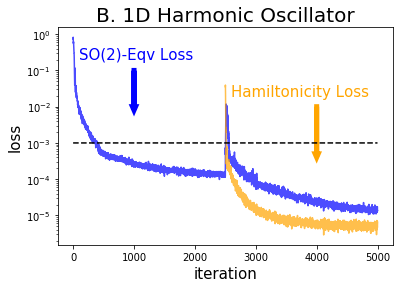

In [34]:
plt.plot(np.arange(epochs), loss[0], color="blue",alpha=0.7)
plt.plot(np.arange(epochs), loss[1], color="orange",alpha=0.7)
plt.yscale('log')
plt.xlabel('iteration', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.arrow(1000,0.1,0,-0.09,head_width=50,head_length=0.002,linewidth=5,color="blue")
plt.text(100, 0.2, "SO(2)-Eqv Loss",fontsize=15, color="blue")
plt.arrow(4000,0.01,0,-0.0095,head_width=50,head_length=0.0001,linewidth=5, color="orange")
plt.text(2600, 0.02, "Hamiltonicity Loss",fontsize=15, color="orange")
plt.plot(np.arange(epochs), np.ones(epochs,)*1e-3, ls="--", color="black")
plt.title('B. 1D Harmonic Oscillator',fontsize=20)
plt.savefig('./figures/1dHO.pdf', bbox_inches="tight")